In [ ]:
# ✅ 專案依賴：torch==1.13.1+cu117, torchvision, segmentation-models-pytorch
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import torch.nn as nn
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2



# === 自定義 Dataset ===
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (256, 256))
        mask = cv2.resize(mask, (256, 256))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]                  # [3, H, W]
            mask = augmented["mask"].unsqueeze(0).float() / 255.0
        else:
            image = transforms.ToTensor()(image)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) / 255.0

        return image, mask


# === 輔助函數：讀取檔案對 ===
def load_image_mask_pairs(img_dir, mask_dir):
    img_paths = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))])
    mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(('.jpg', '.png'))])
    pairs = []
    for img, mask in zip(img_paths, mask_paths):
        img_id = os.path.basename(img).split('.')[0].replace("img_", "")
        mask_id = os.path.basename(mask).split('.')[0].replace("mask_", "")
        if img_id == mask_id:
            pairs.append((img, mask))
    return zip(*pairs)

# === 自定義端點與評估 ===
def find_ett_endpoint(mask):
    if mask.max() <= 1.0:
        mask = (mask * 255).astype(np.uint8)
    non_zero = np.where(mask > 0)
    return -1 if len(non_zero[0]) == 0 else non_zero[0].max()

def calculate_endpoint_metrics(true_masks, pred_masks, P=72):
    true_endpoints = []
    pred_endpoints = []
    for t, p in zip(true_masks, pred_masks):
        yt = find_ett_endpoint(t.squeeze())
        yp = find_ett_endpoint(p.squeeze())
        if yt != -1 and yp != -1:
            true_endpoints.append(yt)
            pred_endpoints.append(yp)
    if not true_endpoints:
        return {"avg_error_cm": float('inf'), "accuracy_05cm": 0.0, "accuracy_10cm": 0.0}
    errors_px = np.abs(np.array(pred_endpoints) - np.array(true_endpoints))
    return {
        "avg_error_cm": np.mean(errors_px) / P,
        "accuracy_05cm": np.mean(errors_px <= P/2) * 100,
        "accuracy_10cm": np.mean(errors_px <= P) * 100
    }

# === IoU metric 手動定義 ===
def iou_score(preds, targets, threshold=0.5, eps=1e-7):
    preds = (preds > threshold).float()
    targets = targets.float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()



# === 資料增強 ===
def get_grayscale_augmented_transform(seed=42):
    # 固定隨機種子
    np.random.seed(seed)
    return A.Compose([        
        A.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), p=1.0),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Normalize(),
        ToTensorV2() 
    ])

def get_val_transform():
    return A.Compose([
        A.Normalize(),
        ToTensorV2()
    ])

# === 視覺化 ===
def visualize_results(images, true_masks, pred_masks, fold):
    plt.figure(figsize=(15, 15))
    for i in range(min(5, len(images))):
        img = images[i].permute(1, 2, 0).numpy()
        true_mask = true_masks[i].squeeze()
        pred_mask = pred_masks[i].squeeze()

        plt.subplot(5, 3, i * 3 + 1)
        plt.imshow(img)
        plt.title("原圖")
        plt.axis('off')

        plt.subplot(5, 3, i * 3 + 2)
        plt.imshow(true_mask, cmap='gray')
        y = find_ett_endpoint(true_mask.numpy())
        if y != -1:
            plt.scatter(128, y, color='red')
        plt.title("真實遮罩")
        plt.axis('off')

        plt.subplot(5, 3, i * 3 + 3)
        plt.imshow(pred_mask, cmap='gray')
        y = find_ett_endpoint(pred_mask.numpy())
        if y != -1:
            plt.scatter(128, y, color='blue')
        plt.title("預測遮罩")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"unet_fold{fold}_results.png")
    plt.show()

# === BCE + Jaccard Loss 自定義 ===
bce = nn.BCEWithLogitsLoss()
jaccard = smp.losses.JaccardLoss(mode='binary')

def bce_jaccard_loss(y_pred, y_true):
    return bce(y_pred, y_true) + jaccard(y_pred, y_true)

# === 個別 fold 訓練 ===
def train_on_fold(fold, data_root):
    print(f"\n🔁 Fold {fold}")
    train_img_dir = os.path.join(data_root, f"Fold{fold}", "train")
    train_mask_dir = os.path.join(data_root, f"Fold{fold}", "trainannot")
    test_img_dir = os.path.join(data_root, f"Fold{fold}", "test")
    test_mask_dir = os.path.join(data_root, f"Fold{fold}", "testannot")

    train_imgs, train_masks = load_image_mask_pairs(train_img_dir, train_mask_dir)
    test_imgs, test_masks = load_image_mask_pairs(test_img_dir, test_mask_dir)

    # train_dataset = SegmentationDataset(train_imgs, train_masks)
    train_dataset = SegmentationDataset(train_imgs, train_masks, transform=get_grayscale_augmented_transform())

    test_dataset = SegmentationDataset(test_imgs, test_masks, transform=get_val_transform())


    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    model = smp.UnetPlusPlus(
    encoder_name="inceptionv4",        # backbone
    encoder_weights="imagenet",            # 使用 ImageNet 預訓練
    in_channels=3,                          # RGB 圖像
    classes=1                               # 二分類遮罩
)
    loss_fn = bce_jaccard_loss
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(1, 21):
        model.train()
        total_loss = 0
        for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch}"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = loss_fn(preds, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch}: Loss = {total_loss/len(train_loader):.4f}")

    model.eval()
    preds, gts, ims = [], [], []
    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs = imgs.to(device)
            out = model(imgs).cpu()
            pred_mask = (out > 0.5).float()
            preds.append(pred_mask[0])
            gts.append(masks[0])
            ims.append(imgs[0].cpu())

    iou = iou_score(torch.stack(preds), torch.stack(gts))
    endpoints = calculate_endpoint_metrics(torch.stack(gts).numpy(), torch.stack(preds).numpy())

    print(f"✅ Fold {fold} IoU: {iou:.4f}")
    print(f"📏 平均端點誤差: {endpoints['avg_error_cm']:.2f} cm")
    print(f"🎯 ±0.5cm: {endpoints['accuracy_05cm']:.1f}%, ±1.0cm: {endpoints['accuracy_10cm']:.1f}%")

    visualize_results(ims, gts, preds, fold)




🔁 Fold 1


Epoch 1: 100%|██████████| 72/72 [00:31<00:00,  2.27it/s]


Epoch 1: Loss = 1.1472


Epoch 2: 100%|██████████| 72/72 [00:32<00:00,  2.24it/s]


Epoch 2: Loss = 0.7090


Epoch 3: 100%|██████████| 72/72 [00:31<00:00,  2.26it/s]


Epoch 3: Loss = 0.5687


Epoch 4: 100%|██████████| 72/72 [00:31<00:00,  2.28it/s]


Epoch 4: Loss = 0.4917


Epoch 5: 100%|██████████| 72/72 [00:31<00:00,  2.29it/s]


Epoch 5: Loss = 0.4573


Epoch 6: 100%|██████████| 72/72 [00:31<00:00,  2.28it/s]


Epoch 6: Loss = 0.4505


Epoch 7: 100%|██████████| 72/72 [00:31<00:00,  2.28it/s]


Epoch 7: Loss = 0.4021


Epoch 8: 100%|██████████| 72/72 [00:31<00:00,  2.28it/s]


Epoch 8: Loss = 0.4138


Epoch 9: 100%|██████████| 72/72 [00:33<00:00,  2.16it/s]


Epoch 9: Loss = 0.3828


Epoch 10: 100%|██████████| 72/72 [00:31<00:00,  2.25it/s]


Epoch 10: Loss = 0.3878


Epoch 11: 100%|██████████| 72/72 [00:31<00:00,  2.27it/s]


Epoch 11: Loss = 0.3686


Epoch 12: 100%|██████████| 72/72 [00:31<00:00,  2.26it/s]


Epoch 12: Loss = 0.3789


Epoch 13: 100%|██████████| 72/72 [00:32<00:00,  2.25it/s]


Epoch 13: Loss = 0.3853


Epoch 14: 100%|██████████| 72/72 [00:31<00:00,  2.25it/s]


Epoch 14: Loss = 0.3729


Epoch 15: 100%|██████████| 72/72 [00:31<00:00,  2.27it/s]


Epoch 15: Loss = 0.3599


Epoch 16: 100%|██████████| 72/72 [00:31<00:00,  2.26it/s]


Epoch 16: Loss = 0.3321


Epoch 17: 100%|██████████| 72/72 [00:32<00:00,  2.21it/s]


Epoch 17: Loss = 0.3285


Epoch 18: 100%|██████████| 72/72 [00:31<00:00,  2.27it/s]


Epoch 18: Loss = 0.3217


Epoch 19: 100%|██████████| 72/72 [00:31<00:00,  2.26it/s]


Epoch 19: Loss = 0.3470


Epoch 20: 100%|██████████| 72/72 [00:31<00:00,  2.26it/s]


Epoch 20: Loss = 0.3280


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.6225708].


✅ Fold 1 IoU: 0.6343
📏 平均端點誤差: 0.17 cm
🎯 ±0.5cm: 91.5%, ±1.0cm: 100.0%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.6225708].
C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 22294 (\N{CJK UNIFIED IDEOGRAPH-5716}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 23526 (\N{CJK UNIFIED IDEOGRAPH-5BE6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 36974 (\N{CJK UNIFIED IDEOGRAPH-906E}) missi

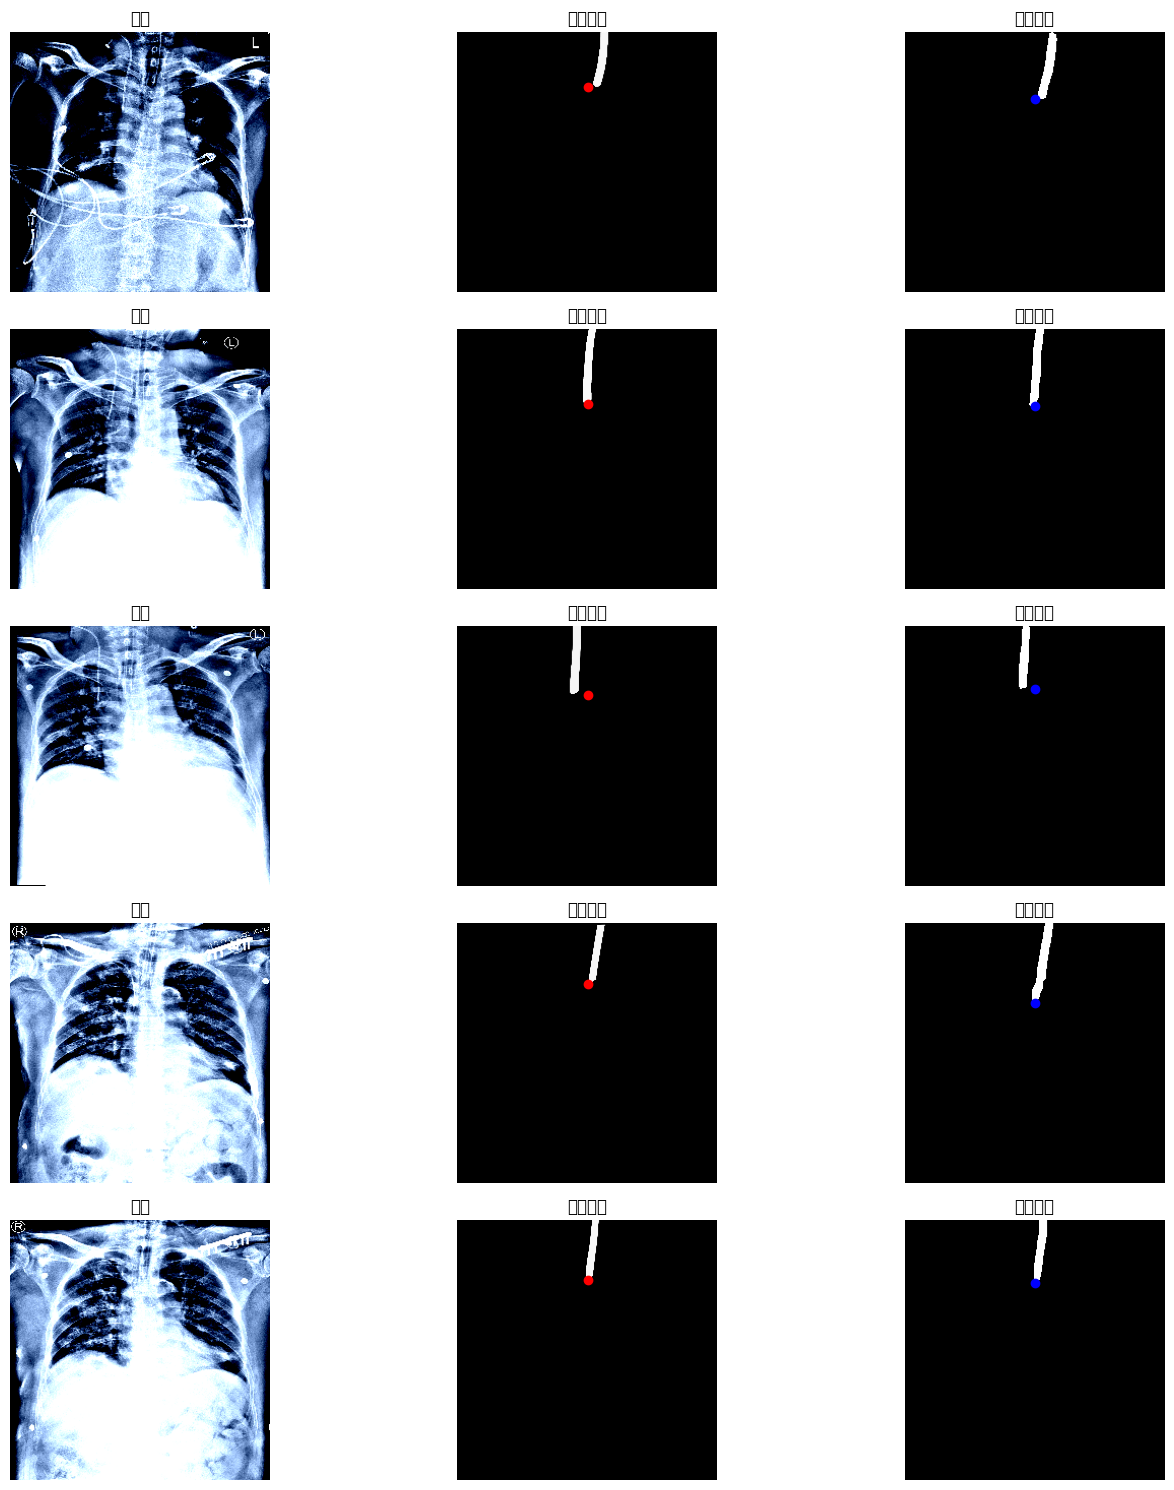

In [9]:
# === 主流程 ===
def main():
    for fold in [1]:
        train_on_fold(fold, data_root="ETT_v3")
    

if __name__ == "__main__":
    main()


🔁 Fold 2


Epoch 1: 100%|██████████| 72/72 [00:31<00:00,  2.27it/s]


Epoch 1: Loss = 1.1372


Epoch 2: 100%|██████████| 72/72 [00:31<00:00,  2.29it/s]


Epoch 2: Loss = 0.6690


Epoch 3: 100%|██████████| 72/72 [00:31<00:00,  2.29it/s]


Epoch 3: Loss = 0.5387


Epoch 4: 100%|██████████| 72/72 [00:31<00:00,  2.28it/s]


Epoch 4: Loss = 0.5008


Epoch 5: 100%|██████████| 72/72 [00:31<00:00,  2.29it/s]


Epoch 5: Loss = 0.4325


Epoch 6: 100%|██████████| 72/72 [00:31<00:00,  2.27it/s]


Epoch 6: Loss = 0.4115


Epoch 7: 100%|██████████| 72/72 [00:31<00:00,  2.29it/s]


Epoch 7: Loss = 0.3966


Epoch 8: 100%|██████████| 72/72 [00:31<00:00,  2.28it/s]


Epoch 8: Loss = 0.3941


Epoch 9: 100%|██████████| 72/72 [00:31<00:00,  2.28it/s]


Epoch 9: Loss = 0.3844


Epoch 10: 100%|██████████| 72/72 [00:31<00:00,  2.28it/s]


Epoch 10: Loss = 0.3662


Epoch 11: 100%|██████████| 72/72 [00:31<00:00,  2.26it/s]


Epoch 11: Loss = 0.3782


Epoch 12: 100%|██████████| 72/72 [00:31<00:00,  2.27it/s]


Epoch 12: Loss = 0.3647


Epoch 13: 100%|██████████| 72/72 [00:31<00:00,  2.27it/s]


Epoch 13: Loss = 0.3734


Epoch 14: 100%|██████████| 72/72 [00:31<00:00,  2.29it/s]


Epoch 14: Loss = 0.3460


Epoch 15: 100%|██████████| 72/72 [00:31<00:00,  2.26it/s]


Epoch 15: Loss = 0.3491


Epoch 16: 100%|██████████| 72/72 [00:31<00:00,  2.28it/s]


Epoch 16: Loss = 0.3669


Epoch 17: 100%|██████████| 72/72 [00:31<00:00,  2.27it/s]


Epoch 17: Loss = 0.3687


Epoch 18: 100%|██████████| 72/72 [00:31<00:00,  2.27it/s]


Epoch 18: Loss = 0.3562


Epoch 19: 100%|██████████| 72/72 [00:31<00:00,  2.27it/s]


Epoch 19: Loss = 0.3543


Epoch 20: 100%|██████████| 72/72 [00:31<00:00,  2.27it/s]


Epoch 20: Loss = 0.3404


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.6225708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.6225708].


✅ Fold 2 IoU: 0.7244
📏 平均端點誤差: 0.08 cm
🎯 ±0.5cm: 97.9%, ±1.0cm: 100.0%


C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 22294 (\N{CJK UNIFIED IDEOGRAPH-5716}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 23526 (\N{CJK UNIFIED IDEOGRAPH-5BE6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 36974 (\N{CJK UNIFIED IDEOGRAPH-906E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 32617 (\

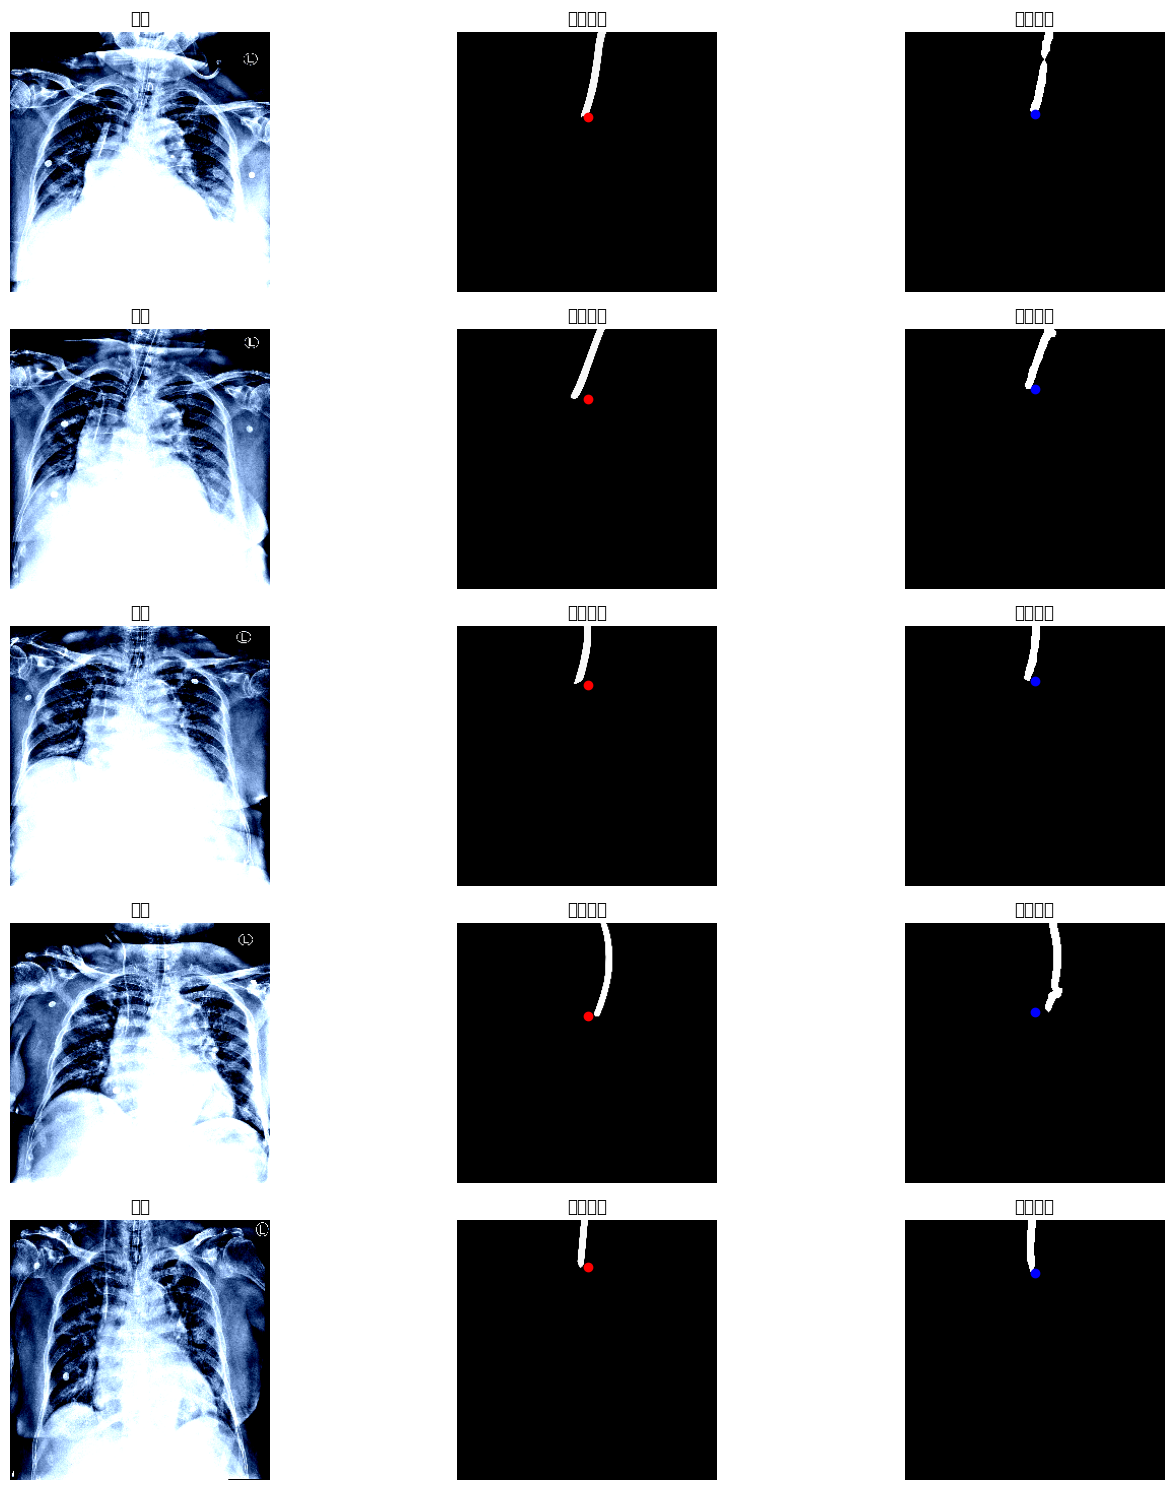

In [10]:
# === 主流程 ===
def main():
    for fold in [2]:
        train_on_fold(fold, data_root="ETT_v3")
    

if __name__ == "__main__":
    main()


🔁 Fold 3


Epoch 1: 100%|██████████| 72/72 [00:31<00:00,  2.29it/s]


Epoch 1: Loss = 0.9472


Epoch 2: 100%|██████████| 72/72 [00:31<00:00,  2.29it/s]


Epoch 2: Loss = 0.5798


Epoch 3: 100%|██████████| 72/72 [00:31<00:00,  2.28it/s]


Epoch 3: Loss = 0.5130


Epoch 4: 100%|██████████| 72/72 [00:31<00:00,  2.30it/s]


Epoch 4: Loss = 0.4673


Epoch 5: 100%|██████████| 72/72 [00:31<00:00,  2.29it/s]


Epoch 5: Loss = 0.4509


Epoch 6: 100%|██████████| 72/72 [00:31<00:00,  2.29it/s]


Epoch 6: Loss = 0.4196


Epoch 7: 100%|██████████| 72/72 [00:32<00:00,  2.24it/s]


Epoch 7: Loss = 0.3932


Epoch 8: 100%|██████████| 72/72 [00:32<00:00,  2.21it/s]


Epoch 8: Loss = 0.3948


Epoch 9: 100%|██████████| 72/72 [00:32<00:00,  2.21it/s]


Epoch 9: Loss = 0.3628


Epoch 10: 100%|██████████| 72/72 [00:32<00:00,  2.19it/s]


Epoch 10: Loss = 0.3654


Epoch 11: 100%|██████████| 72/72 [00:32<00:00,  2.23it/s]


Epoch 11: Loss = 0.3649


Epoch 12: 100%|██████████| 72/72 [00:32<00:00,  2.22it/s]


Epoch 12: Loss = 0.3406


Epoch 13: 100%|██████████| 72/72 [00:32<00:00,  2.21it/s]


Epoch 13: Loss = 0.3406


Epoch 14: 100%|██████████| 72/72 [00:33<00:00,  2.18it/s]


Epoch 14: Loss = 0.3403


Epoch 15: 100%|██████████| 72/72 [00:32<00:00,  2.20it/s]


Epoch 15: Loss = 0.3315


Epoch 16: 100%|██████████| 72/72 [00:32<00:00,  2.19it/s]


Epoch 16: Loss = 0.3313


Epoch 17: 100%|██████████| 72/72 [00:32<00:00,  2.18it/s]


Epoch 17: Loss = 0.3241


Epoch 18: 100%|██████████| 72/72 [00:31<00:00,  2.25it/s]


Epoch 18: Loss = 0.3350


Epoch 19: 100%|██████████| 72/72 [00:31<00:00,  2.28it/s]


Epoch 19: Loss = 0.3204


Epoch 20: 100%|██████████| 72/72 [00:31<00:00,  2.29it/s]


Epoch 20: Loss = 0.3182


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.6225708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6399999].


✅ Fold 3 IoU: 0.6937
📏 平均端點誤差: 0.12 cm
🎯 ±0.5cm: 97.9%, ±1.0cm: 100.0%


C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 22294 (\N{CJK UNIFIED IDEOGRAPH-5716}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 23526 (\N{CJK UNIFIED IDEOGRAPH-5BE6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 36974 (\N{CJK UNIFIED IDEOGRAPH-906E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 32617 (\

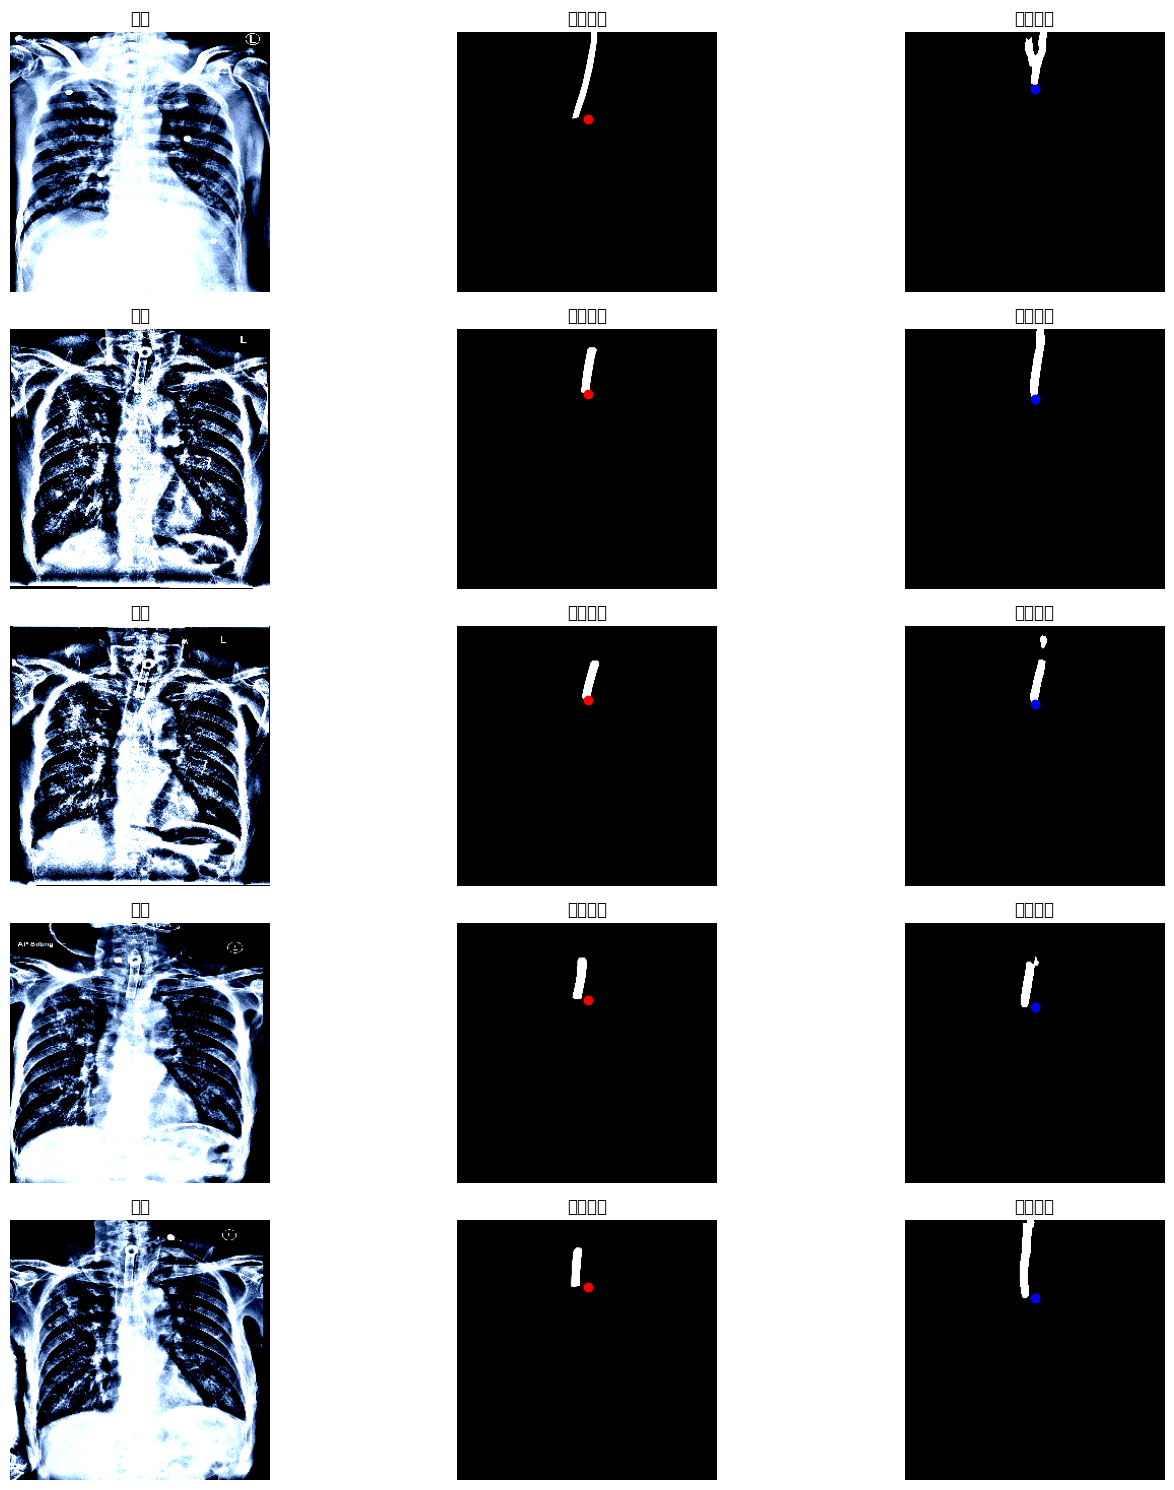

In [11]:
# === 主流程 ===
def main():
    for fold in [3]:
        train_on_fold(fold, data_root="ETT_v3")
    

if __name__ == "__main__":
    main()


🔁 Fold 4


Epoch 1: 100%|██████████| 72/72 [00:34<00:00,  2.08it/s]


Epoch 1: Loss = 0.9329


Epoch 2: 100%|██████████| 72/72 [00:32<00:00,  2.23it/s]


Epoch 2: Loss = 0.5827


Epoch 3: 100%|██████████| 72/72 [00:31<00:00,  2.29it/s]


Epoch 3: Loss = 0.4854


Epoch 4: 100%|██████████| 72/72 [00:31<00:00,  2.26it/s]


Epoch 4: Loss = 0.4469


Epoch 5: 100%|██████████| 72/72 [00:32<00:00,  2.20it/s]


Epoch 5: Loss = 0.4554


Epoch 6: 100%|██████████| 72/72 [00:32<00:00,  2.24it/s]


Epoch 6: Loss = 0.4389


Epoch 7: 100%|██████████| 72/72 [00:31<00:00,  2.27it/s]


Epoch 7: Loss = 0.4214


Epoch 8: 100%|██████████| 72/72 [00:31<00:00,  2.29it/s]


Epoch 8: Loss = 0.3794


Epoch 9: 100%|██████████| 72/72 [00:31<00:00,  2.27it/s]


Epoch 9: Loss = 0.3802


Epoch 10: 100%|██████████| 72/72 [00:31<00:00,  2.28it/s]


Epoch 10: Loss = 0.3711


Epoch 11: 100%|██████████| 72/72 [00:31<00:00,  2.28it/s]


Epoch 11: Loss = 0.3619


Epoch 12: 100%|██████████| 72/72 [00:31<00:00,  2.30it/s]


Epoch 12: Loss = 0.4239


Epoch 13: 100%|██████████| 72/72 [00:31<00:00,  2.29it/s]


Epoch 13: Loss = 0.3730


Epoch 14: 100%|██████████| 72/72 [00:31<00:00,  2.28it/s]


Epoch 14: Loss = 0.3265


Epoch 15: 100%|██████████| 72/72 [00:31<00:00,  2.28it/s]


Epoch 15: Loss = 0.3388


Epoch 16: 100%|██████████| 72/72 [00:31<00:00,  2.28it/s]


Epoch 16: Loss = 0.3502


Epoch 17: 100%|██████████| 72/72 [00:31<00:00,  2.29it/s]


Epoch 17: Loss = 0.3551


Epoch 18: 100%|██████████| 72/72 [00:31<00:00,  2.29it/s]


Epoch 18: Loss = 0.3545


Epoch 19: 100%|██████████| 72/72 [00:31<00:00,  2.28it/s]


Epoch 19: Loss = 0.3611


Epoch 20: 100%|██████████| 72/72 [00:31<00:00,  2.30it/s]


Epoch 20: Loss = 0.3631


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6225708].


✅ Fold 4 IoU: 0.6567
📏 平均端點誤差: 0.09 cm
🎯 ±0.5cm: 97.9%, ±1.0cm: 100.0%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6225708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6225708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6399999].
C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 22294 (\N{CJK UNIFIED IDEOGRAPH-5716}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\

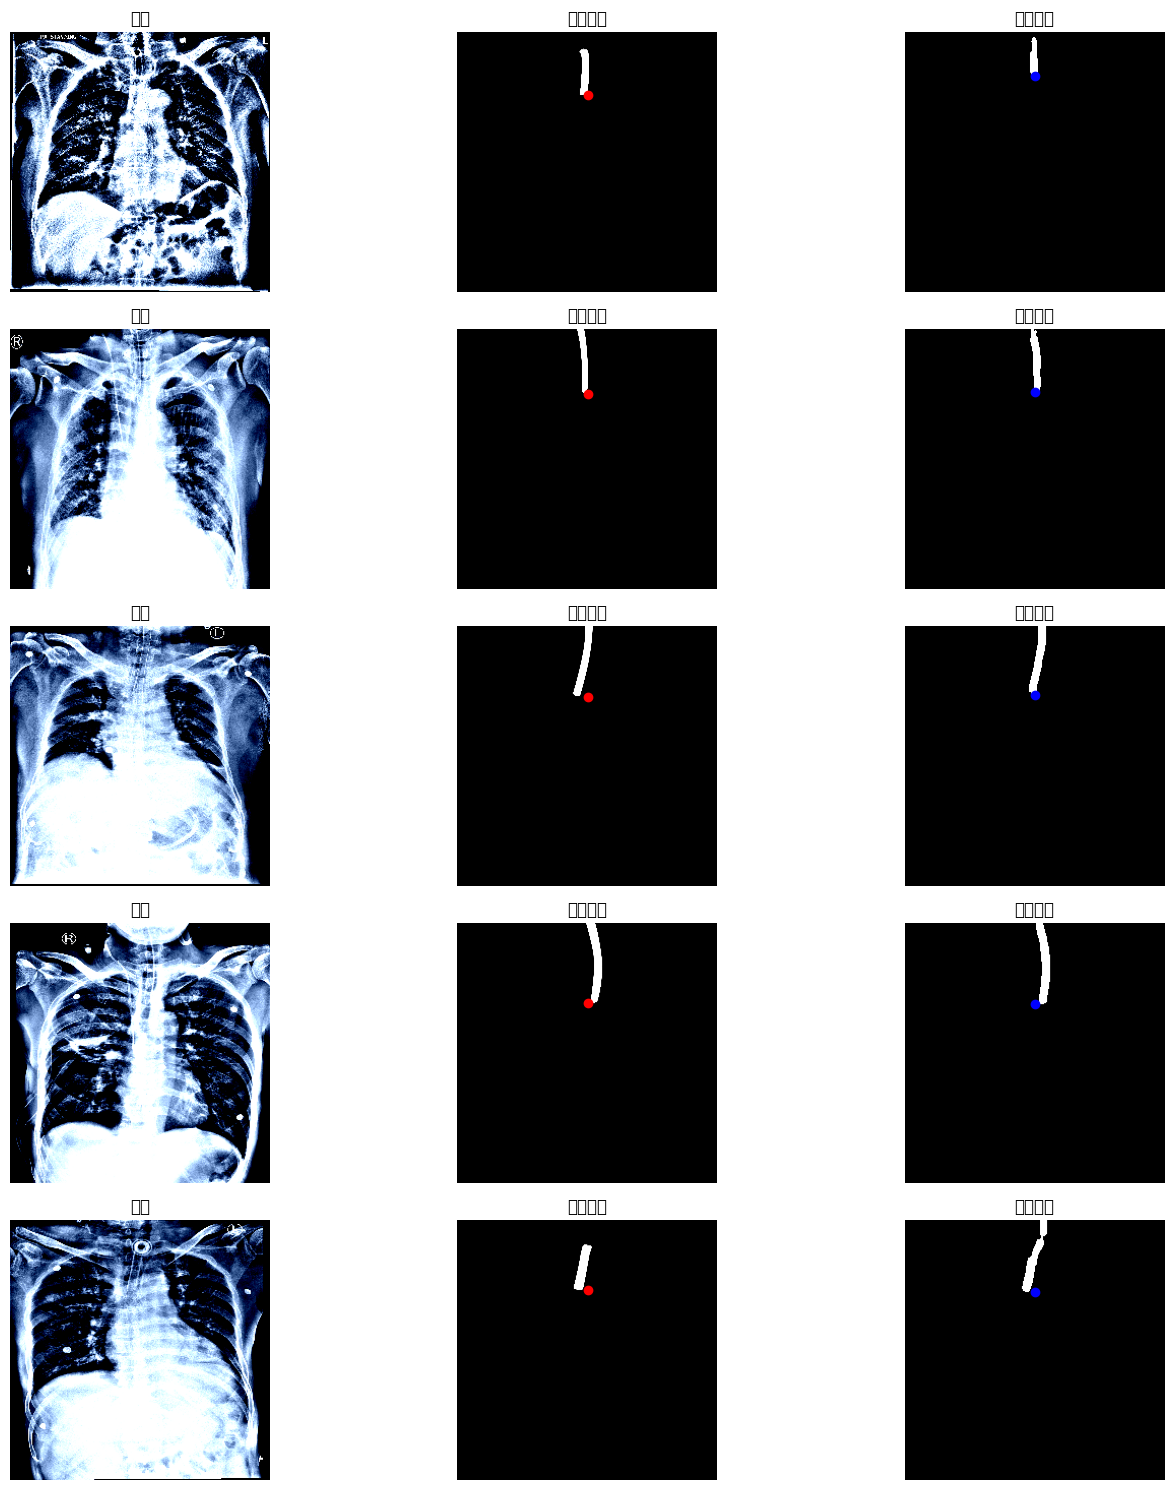

In [12]:
# === 主流程 ===
def main():
    for fold in [4]:
        train_on_fold(fold, data_root="ETT_v3")
    

if __name__ == "__main__":
    main()


🔁 Fold 5


Epoch 1: 100%|██████████| 72/72 [00:35<00:00,  2.04it/s]


Epoch 1: Loss = 1.0418


Epoch 2: 100%|██████████| 72/72 [00:31<00:00,  2.28it/s]


Epoch 2: Loss = 0.6318


Epoch 3: 100%|██████████| 72/72 [00:31<00:00,  2.26it/s]


Epoch 3: Loss = 0.5248


Epoch 4: 100%|██████████| 72/72 [00:31<00:00,  2.28it/s]


Epoch 4: Loss = 0.4908


Epoch 5: 100%|██████████| 72/72 [00:32<00:00,  2.23it/s]


Epoch 5: Loss = 0.4287


Epoch 6: 100%|██████████| 72/72 [00:32<00:00,  2.18it/s]


Epoch 6: Loss = 0.4130


Epoch 7: 100%|██████████| 72/72 [00:32<00:00,  2.22it/s]


Epoch 7: Loss = 0.4366


Epoch 8: 100%|██████████| 72/72 [00:31<00:00,  2.25it/s]


Epoch 8: Loss = 0.3948


Epoch 9: 100%|██████████| 72/72 [00:32<00:00,  2.19it/s]


Epoch 9: Loss = 0.3958


Epoch 10: 100%|██████████| 72/72 [00:32<00:00,  2.22it/s]


Epoch 10: Loss = 0.3777


Epoch 11: 100%|██████████| 72/72 [00:32<00:00,  2.19it/s]


Epoch 11: Loss = 0.3632


Epoch 12: 100%|██████████| 72/72 [00:32<00:00,  2.19it/s]


Epoch 12: Loss = 0.3904


Epoch 13: 100%|██████████| 72/72 [00:32<00:00,  2.20it/s]


Epoch 13: Loss = 0.3605


Epoch 14: 100%|██████████| 72/72 [00:32<00:00,  2.20it/s]


Epoch 14: Loss = 0.3607


Epoch 15: 100%|██████████| 72/72 [00:32<00:00,  2.20it/s]


Epoch 15: Loss = 0.3405


Epoch 16: 100%|██████████| 72/72 [00:31<00:00,  2.26it/s]


Epoch 16: Loss = 0.3333


Epoch 17: 100%|██████████| 72/72 [00:31<00:00,  2.26it/s]


Epoch 17: Loss = 0.3434


Epoch 18: 100%|██████████| 72/72 [00:33<00:00,  2.17it/s]


Epoch 18: Loss = 0.3230


Epoch 19: 100%|██████████| 72/72 [00:32<00:00,  2.19it/s]


Epoch 19: Loss = 0.3213


Epoch 20: 100%|██████████| 72/72 [00:32<00:00,  2.20it/s]


Epoch 20: Loss = 0.3250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.6225708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6225708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


✅ Fold 5 IoU: 0.7674
📏 平均端點誤差: 0.16 cm
🎯 ±0.5cm: 95.8%, ±1.0cm: 95.8%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.6225708].
C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 22294 (\N{CJK UNIFIED IDEOGRAPH-5716}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 23526 (\N{CJK UNIFIED IDEOGRAPH-5BE6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15460\1944056382.py:142: UserWarning: Glyph 36974 (\N{CJK UNIFIED IDEOGRAPH-906E}) missi

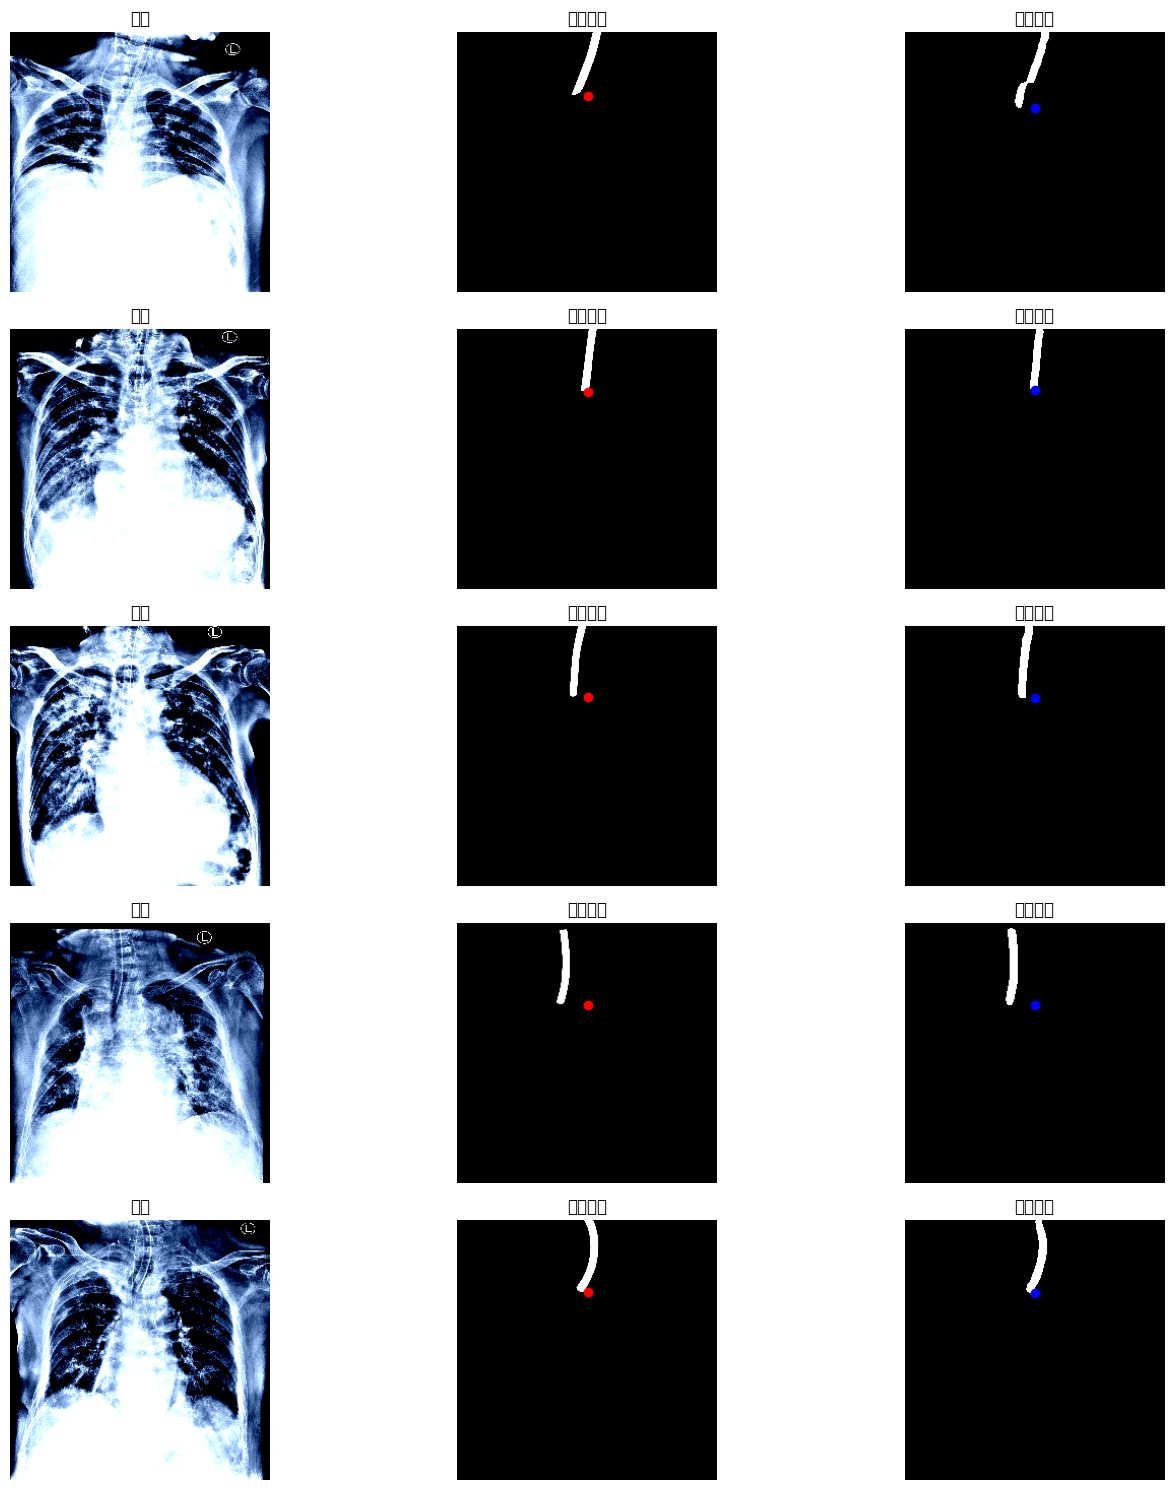

In [13]:
# === 主流程 ===
def main():
    for fold in [5]:
        train_on_fold(fold, data_root="ETT_v3")
    

if __name__ == "__main__":
    main()